## Objective
Let's do some quick and dirty analysis fo the the [Epstine Docs](https://www.documentcloud.org/documents/6250471-Epstein-Docs) using SpaCy, PdfPlumber, and Pandas. Our goal is to  extract people, organizations, and locations and make some wordclouds. Why? because everyone needs a wordcloud : )

> *note: "Quick and Dirty" clearly there is alot that can be done with this data, this is just a sample to have some fun with a large text document.*

## Tools and Libraries
We will be leveraging a combination of  libraries to facilitate our analysis:

1. **pdfplumber**: A Python library specifically designed for extracting text from PDF files. We will use pdfplumber to convert the PDF content into a text format.

2. **Pandas**: We will utilize Pandas for organizing the extracted text into a structured DataFrame because i hate dealing with lists and dictionaries for analysis.

3. **SpaCy**: A great NLP library used for various Named Entity Recognition (NER) tasks. SpaCy will be used to identify our entities.

## Workflow Overview
Our analysis will proceed through the following steps:
0. ** Install Spacy and PDF Plumber**
1. ** Download [Epstine-Docs.pdf](https://www.documentcloud.org/documents/6250471-Epstein-Docs)
2. **PDF Text Extraction**: Using `pdfplumber` to read the PDF document and extract its content into a continuous text format.
  - [pdfplumber](https://pypi.org/project/pdfplumber/)
3. **Text to DataFrame Conversion**: Transforming the extracted text into a structured DataFrame using Pandas ~  splitting the text into lines and columns.
4. **Data Cleaning and Preparation**: Cleaning and preprocessing the data ~ essetnailly get rid of junk!  
5. **Named Entity Recognition with SpaCy**: Applying SpaCy NER funtionality and extract entities categorized as people, organizations, and locations put them into a dataframe for more cleaning.
 - [spaCy](https://spacy.io/)
6. **Entity Data Cleaning and Structuring**: Further cleaning and structuring the extracted entity data for clarity and ease of analysis.
7. **Data Summarization and Presentation**: Summarizing the data and make some barcharts and wordclouds.


In [2]:
# step one install spacy and pdfplumber!
!pip install spacy pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 870.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 19.4 MB/s eta 0:00:00


In [3]:
# load our libraries
import warnings
warnings.filterwarnings('ignore')

# standard libries
import re
import io
import string
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# spacy, pdfplumber and wordcloud
import pdfplumber
import spacy
from wordcloud import WordCloud


## Get the PDF

In [4]:
# URL of the PDF file
pdf_url = "https://s3.documentcloud.org/documents/6250471/Epstein-Docs.pdf"

# Send a GET request to download the PDF
response = requests.get(pdf_url)

# Check if the request was successful
if response.status_code == 200:
    # Write the content of the response to a PDF file
    with open("Epstein-Docs.pdf", "wb") as file:
        file.write(response.content)
    print("PDF downloaded successfully.")
else:
    print("Failed to download the PDF. Status code:", response.status_code)


PDF downloaded successfully.


# Convert PDF to Pandas DataFrame


---

2. PDF Text Extraction: Using pdfplumber to read the PDF document and extract its content into a continuous text format.
pdfplumber
3. Text to DataFrame Conversion: Transforming the extracted text into a structured DataFrame using Pandas ~ splitting the text into lines and columns.

In [5]:
# prompt: convert pdf to text into pandas dataframe

def pdf_to_text(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        pages = pdf.pages
        text = ""
        for page in pages:
            text += page.extract_text()
    return text

def text_to_df(text):
    lines = text.split("\n")
    columns = lines[0].split("\t")
    data = []
    for line in lines[1:]:
        values = line.split("\t")
        data.append(values)
    return pd.DataFrame(data, columns=columns)

pdf_path = "/content/Epstein-Docs.pdf"
text = pdf_to_text(pdf_path)
df = text_to_df(text)
df.head()


,"Case 18-2868, Document 271, 08/09/2019, 2628203, Page1 of 1"
0,UNITED STATES COURT OF APPEALS
1,FOR THE
2,SECOND CIRCUIT
3,_____________________________________________
4,At a stated term of the United States Court of...


## Start the Cleaning


---



In [6]:
df.columns = ['text']
df['text'] = (df['text']
              .str.replace('\n', ' ')
              .str.replace('\t', ' ')
              .str.replace('  ', ' ')
              .str.lower()
              .str.strip()
              .str.replace('_', '')
              .str.replace('box', '')
)
df = (df
      .query('text != ""'))

df.head()

,text
0,united states court of appeals
1,for the
2,second circuit
4,at a stated term of the united states court of...
5,"thurgood marshall united states courthouse, 40..."


In [7]:
# save that mofo
df.to_csv("epstine_parsed.csv",index=False)

In [8]:
# Load the English language model
nlp = spacy.load('en_core_web_sm')

# cast our tweets to a list  text data
text_list = df["text"].to_list()

exclude_patterns = ["http", "https:", "t.co", "t", "co", "year", "day", "box", "️\n"]
named_entities = []

for text in text_list:
    doc = nlp(text)
    for ent in doc.ents:
        if not any(pattern in ent.text.lower() for pattern in exclude_patterns):
            if not ent.text.isdigit() and not re.match("^[0-9]+[/][0-9]+[/][0-9]+$", ent.text):
                named_entities.append((ent.text, ent.label_))

# Convert the list of tuples to a Pandas DataFrame
entity_df = pd.DataFrame(named_entities, columns=['entity', 'entity_type'])
entity_df.query("entity_type == 'PERSON'").head(10)


,entity,entity_type
2,julie brown,PERSON
3,v. order,PERSON
4,ghislaine maxwell,PERSON
5,virginia l. giuffre,PERSON
6,appellee,PERSON
7,ghislaine maxwell,PERSON
11,rsp,PERSON
22,josé a. cabranes,PERSON
23,rosemary s. pooler,PERSON
24,julie brown,PERSON


In [9]:
regex_pattern = r'[^a-zA-Z0-9\s]'

# Replace all found occurrences of the pattern with an empty string
entity_df['entity'] = entity_df['entity'].str.replace(regex_pattern, '', regex=True)
entity_df['entity'] = entity_df['entity'].str.replace(regex_pattern, 'box', regex=True)

entity_df['length'] = entity_df['entity'].str.len()
res0 = (entity_df
        .query('entity_type.isin(["PERSON","ORG","GPE"])')
        .query('length < 50 and length > 1')
        .groupby(["entity", "entity_type"])
        .agg(freq=("entity_type", "count"))
        .reset_index()
        .sort_values("freq",ascending=False)
        .reset_index(drop=True)
        )
res0


,entity,entity_type,freq
0,giuffre,PERSON,683
1,maxwell,PERSON,409
2,maxwell,ORG,336
3,virginia,GPE,332
4,pagliuca,PERSON,244
...,...,...,...
1456,joseph,PERSON,1
1457,76,PERSON,1
1458,cid24cid25cid3,ORG,1
1459,jrlqjcid3wrcid3cid90runcid3irucid3hiicid17,PERSON,1


In [10]:
res0.to_csv("epstine_entity.csv",index=False)

# Visualizing Entities


---

I start my visualizations with BAR Charts of TOP N Entities. I then use Wordclouds to visualize my entities of interest. Pretty easy!

- FIRST SUMMARIZE
- THEN VISUALIZE



In [11]:
# top 5 people
res1 = (entity_df
        .query("entity_type == 'PERSON'")
        .groupby("entity")
        .agg(freq=("entity_type", "count"))
        .reset_index()
        .sort_values("freq",ascending=False)
        #.head(5)
)
res1

res2 = (entity_df
        .query("entity_type == 'GPE'")
        .groupby("entity")
        .agg(freq=("entity_type", "count"))
        .reset_index()
        .sort_values("freq",ascending=False)
        #.head(5)
)
res2

res3 = (entity_df
        .query("entity_type == 'ORG'")
        .groupby("entity")
        .agg(freq=("entity_type", "count"))
        .reset_index()
        .sort_values("freq",ascending=False)
        #.head(5)
)
res3

,entity,freq
1105,maxwell,336
0,,90
228,cid3,64
1263,recarey,41
1,,35
...,...,...
540,cid62cid48cid86cid17cid3cid48cid68cid91cid90ci...,1
539,cid62cid48cid86cid17cid3cid48cid68cid91cid90ci...,1
538,cid61cid68cid85cid72cid87cid86cid78cid92cid3ci...,1
537,cid60cid82cid85cid78cid3cid79cid68cid90cid15ci...,1


In [12]:
res1.to_csv("res1_people.csv")
res2.to_csv("res2_places.csv")
res3.to_csv("res3_org.csv")


In [13]:
# prompt: filter out anything that contains a number

entity_df['entity'] = entity_df['entity'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)


In [14]:
 # Regular expression pattern to match "word v word"
legal_case_pattern = r'\b\w+\s+v\s+\w+\b'
page_pattern = r'\bpage'
cid_pattern = r'\bcid\b'
number_pattern = r'\d'
giuffre_pattern = r'\bgiuffre\d'
v_pattern = r'v\s\w'
a_pattern = r'a\s\w'
# Use str.contains() to filter the dataframe
df_legal_cases = res1[res1['entity'].str.contains(legal_case_pattern, case=False, na=False)]
res1a = res1[~res1['entity'].str.contains(legal_case_pattern, case=False, na=False)]
res1a = res1a[~res1a['entity'].str.contains(page_pattern , case=False, na=False)]
res1a = res1a[~res1a['entity'].str.contains(cid_pattern , case=False, na=False)]
res1a = res1a[~res1a['entity'].str.contains(giuffre_pattern , case=False, na=False)]
res1a = res1a[~res1a['entity'].str.contains(number_pattern , case=False, na=False)]
res1a = res1a[~res1a['entity'].str.contains(v_pattern , case=False, na=False)]
res1a = res1a[~res1a['entity'].str.contains(a_pattern , case=False, na=False)]

# length
res1a = res1a[res1a['entity'].str.len()>2]

df_legal_cases.to_csv("legal_cases.csv")
res1a.to_csv("res1_people.csv")

In [29]:
 # Regular expression pattern to match "word v word"
legal_case_pattern = r'\b\w+\s+v\s+\w+\b'
page_pattern = r'\bpage'
cid_pattern = r'\bcid\b'
number_pattern = r'\d'
giuffre_pattern = r'\bgiuffre\d'
v_pattern = r'v\s\w'
a_pattern = r'a\s\w'

loc_filter = ['virginia', 'san','jjcase','aka', 'exp', 'sdny', 'esq']

# Use str.contains() to filter the dataframe
df_legal_cases2 = res2[res2['entity'].str.contains(legal_case_pattern, case=False, na=False)]
res2a = res2[~res2['entity'].str.contains(legal_case_pattern, case=False, na=False)]
res2a = res2a[~res2a['entity'].str.contains(page_pattern , case=False, na=False)]
res2a = res2a[~res2a['entity'].str.contains(cid_pattern , case=False, na=False)]
res2a = res2a[~res2a['entity'].str.contains(giuffre_pattern , case=False, na=False)]
res2a = res2a[~res2a['entity'].str.contains(number_pattern , case=False, na=False)]
res2a = res2a[~res2a['entity'].isin(loc_filter)]

# length
res2a = res2a[res2a['entity'].str.len()>2]

df_legal_cases2.to_csv("legal_cases2.csv")
res2a.to_csv("res2_places.csv")

In [53]:
 # Regular expression pattern to match "word v word"
legal_case_pattern = r'\b\w+\s+v\s+\w+\b'
page_pattern = r'\bpage'
cid_pattern = r'\bcid\b'
number_pattern = r'\d'
giuffre_pattern = r'\bgiuffre\d'
v_pattern = r'v\s\w'
a_pattern = r'a\s\w'

org_filter = ['virginia','maxwell',
              'inc', 'san','jjcase',
              'aka', 'exp', 'sdny',
              'fed', 'recarey','crr','alex',
              'khalil',
'haddon',
'vrs',
'januar',
'boies schiller  flexner',
'jeffrey',
'esq',
'liame',
'morgan  foreman',
'ecf',
'exc',
'gow',
'house',
'rodgers dep',
'james',
'i ms',
'schiller  flexner',
'juan',
'michael',
'exsa  b',
'fdida',
'v casa',
'exa',
'via',
'wang',
'maxwell dep',
'jennifer',
'adriana',
'avenue',
'exs',
'efm',
'x d',
'sys inc',
'v wells fargo bank',
'v sf',
'v hsbc bank usa',
'v home',
'y  m',
'w  w',
'sec',
'saf',
'q a crossreference',
'q mr gow',
'rmr',
'rodger',
'ross gow',
'ioli gina',
'campbell',
'chris',
'kenney',
'maxwell anywhere',
'maxwell know',
'maxwell virginia']

# Use str.contains() to filter the dataframe
df_legal_cases3 = res3[res3['entity'].str.contains(legal_case_pattern, case=False, na=False)]
res3a = res3[~res3['entity'].str.contains(legal_case_pattern, case=False, na=False)]
res3a['entity'] = res3a['entity'].str.strip()
res3a = res3a[~res3a['entity'].str.contains(page_pattern , case=False, na=False)]
res3a = res3a[~res3a['entity'].str.contains(cid_pattern , case=False, na=False)]
res3a = res3a[~res3a['entity'].str.contains(giuffre_pattern , case=False, na=False)]
res3a = res3a[~res3a['entity'].str.contains(number_pattern , case=False, na=False)]
res3a = res3a[~res3a['entity'].isin(org_filter)]

# length
res3a = res3a[res3a['entity'].str.len()>2]

df_legal_cases3.to_csv("legal_cases2.csv")
res3a.to_csv("res3_org.csv")

In [54]:
res3a

,entity,freq
985,fbi,33
80,boeing,17
1127,morgan,9
994,foreman pc,8
83,boies schiller flexner llp,8
...,...,...
1113,mcdonald deborah,1
1115,media ms,1
1117,mesa uenoi,1
65,air inc,1


,entity,freq


# Bar Charts = Top N


---



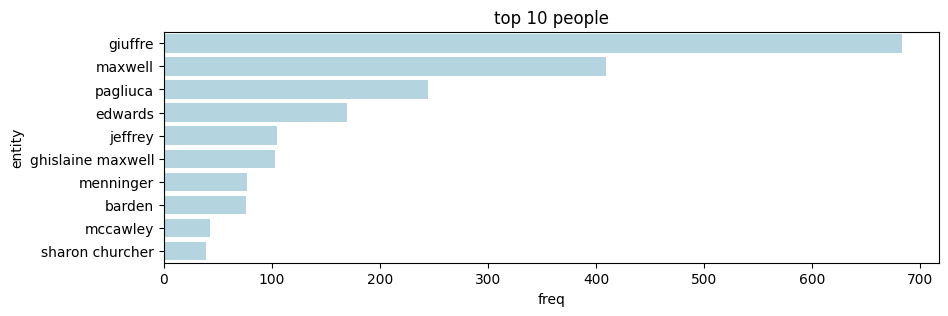

In [56]:
plt.figure(figsize=(10,3))
sns.barplot(res1a.nlargest(10,'freq'),x="freq",y="entity", color="lightblue")
plt.title("top 10 people");

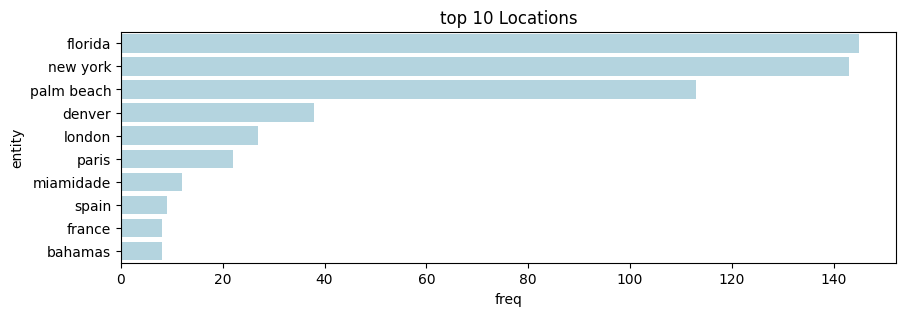

In [57]:
plt.figure(figsize=(10,3))
sns.barplot(res2a.nlargest(10,'freq'),x="freq",y="entity", color="lightblue")
plt.title("top 10 Locations");

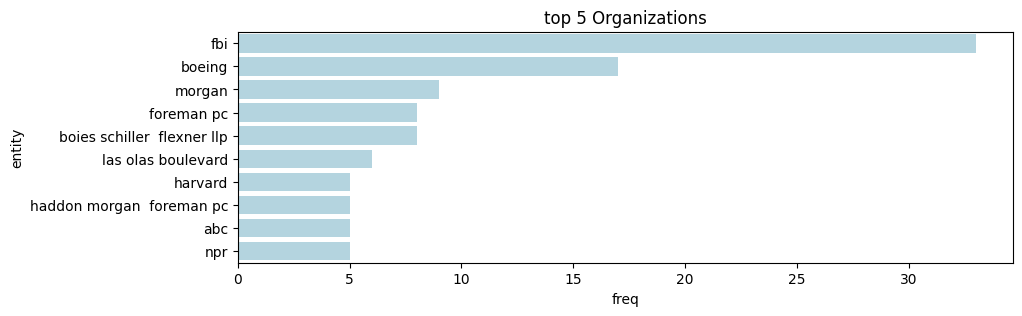

In [58]:
plt.figure(figsize=(10,3))
sns.barplot(res3a.nlargest(10,'freq'),x="freq",y="entity", color="lightblue")
plt.title("top 5 Organizations");

# Word Clouds


---



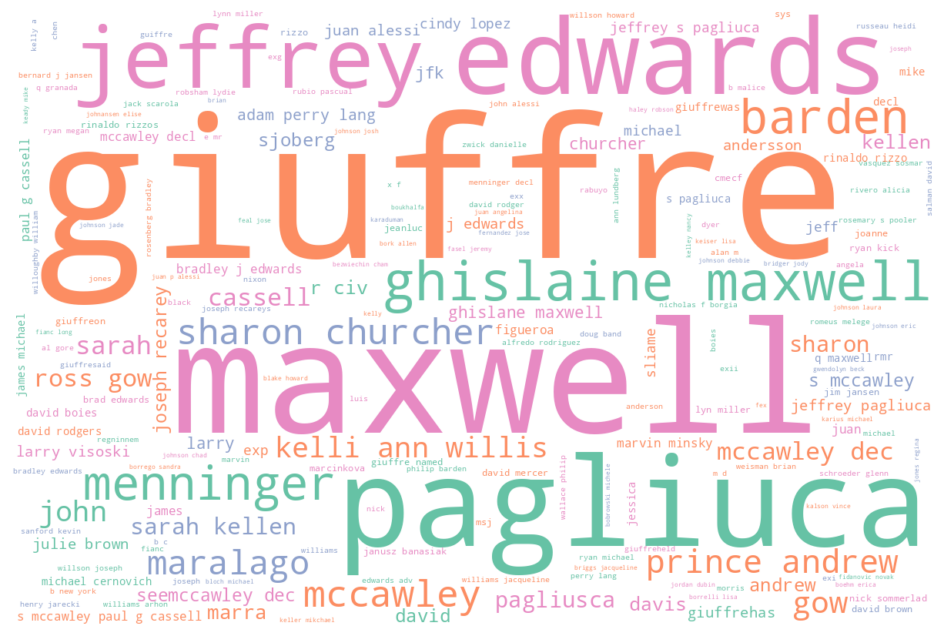

In [59]:
import random
# create a dictionary of entity frequency counts

# people
res1 = (res1a
        .sort_values("freq",ascending=False)
)

# create a dictionary
freq_dict = dict(zip(res1['entity'], res1['freq']))

# Create the wordcloud object with random colors
wordcloud = WordCloud(background_color='white', width=1200, height=800, color_func=lambda *args, **kwargs: random.choice(['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']))\
    .generate_from_frequencies(freq_dict)

# Display the wordcloud
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

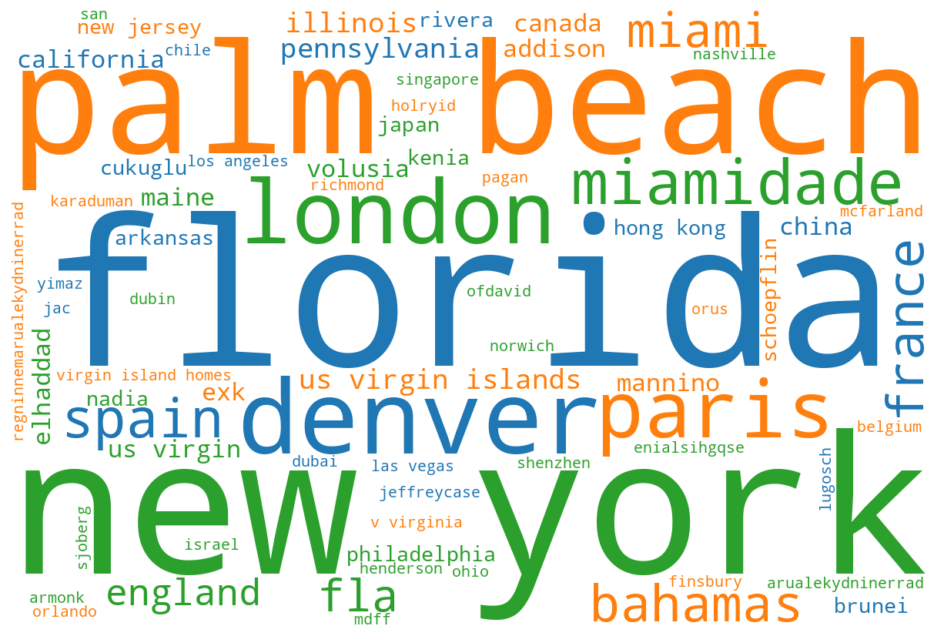

In [60]:
import random

res2 = (res2a
        .sort_values("freq",ascending=False)
)

# Create a list of three colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create the LinearSegmentedColormap object
from matplotlib.colors import ListedColormap
cmap = ListedColormap(colors)


# create a dictionary of entity frequency counts
freq_dict = dict(zip(res2['entity'], res2['freq']))

# Create the wordcloud object with random colors
wordcloud = WordCloud(background_color='white', width=1200, height=800, colormap=cmap)\
    .generate_from_frequencies(freq_dict)

# Display the wordcloud
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

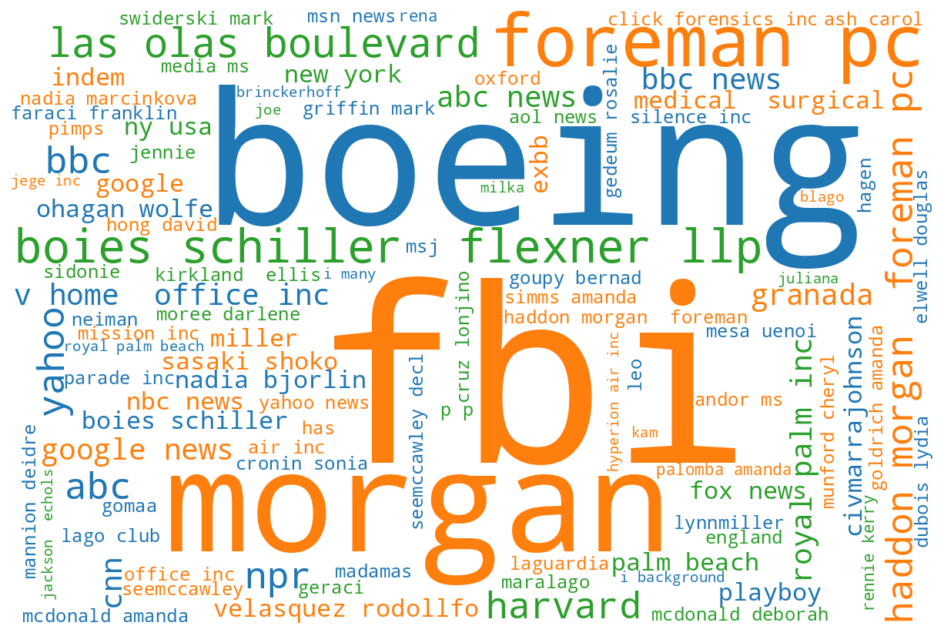

In [61]:

res3 = (res3a
        .sort_values("freq",ascending=False)
)


# Create a list of three colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create the LinearSegmentedColormap object
from matplotlib.colors import ListedColormap
cmap = ListedColormap(colors)

# create a dictionary of entity frequency counts
freq_dict = dict(zip(res3['entity'], res3['freq']))

# Create the wordcloud object with random colors
wordcloud = WordCloud(background_color='white', width=1200, height=800, colormap=cmap)\
    .generate_from_frequencies(freq_dict)

# Display the wordcloud
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()